In [ ]:
%pip install pyyaml==6.0.1
%pip install 'git+https://github.com/facebookresearch/detectron2.git'
%pip install torch
%pip install torchvision
%pip install pycocotools>=2.0.7
%pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
%pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch2.2.1/index.html
%pip install opencv-python
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/detectron2.git'"


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch2.2.1/index.htmlNote: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import json
import random
import cv2
import torch
import tensorboard
from matplotlib import pyplot as plt
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [ ]:
import zipfile

zip_file = 'DATASETS.zip'
extract_folder = './'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [2]:
MODEL="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

TRAIN_DATASET_NAME="colonies_train"
TEST_DATASET_NAME="colonies_test"

In [3]:
register_coco_instances(TRAIN_DATASET_NAME, {}, "./DATASET_BIG/dataset/annotations.json", "./DATASET_BIG/dataset")

In [4]:
MetadataCatalog.get(TRAIN_DATASET_NAME)

namespace(name='colonies_train',
          json_file='./DATASET_BIG/dataset/annotations.json',
          image_root='./DATASET_BIG/dataset',
          evaluator_type='coco')

In [53]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = (TRAIN_DATASET_NAME,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1020
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [54]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
cfg.DATASETS.TEST = (TRAIN_DATASET_NAME,)
predictor = DefaultPredictor(cfg)

# show train results
train_dataset_catalog = DatasetCatalog.get(TRAIN_DATASET_NAME)
train_dataset_metadata = MetadataCatalog.get(TRAIN_DATASET_NAME)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



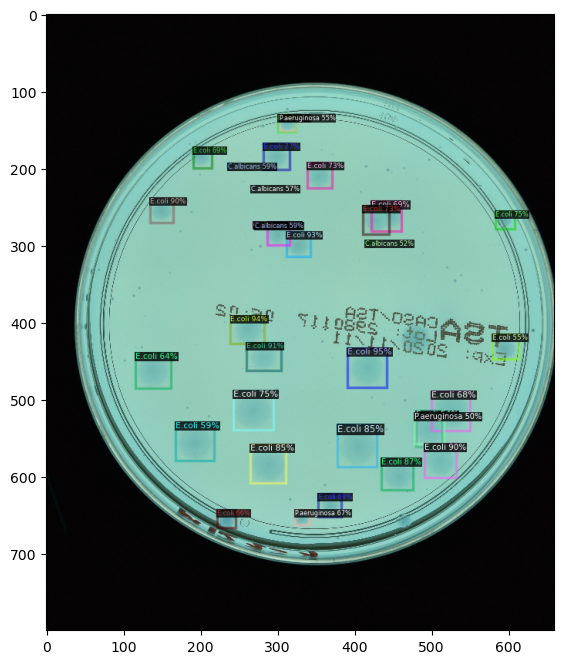

In [51]:
for d in random.sample(train_dataset_catalog, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_dataset_metadata,
                   scale=0.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(8, 8))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [7]:
%reload_ext tensorboard
%tensorboard --logdir output

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.